# Modeller
All baselines are run on the same test set i.e. a subset of the original data set. 
The baselines included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Plain Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model -
- Xgboost regression model without sensitive attributes - 

Fair model:
- Xgboost regression model account for diversity 


In [48]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle


## Plots setup


In [49]:

def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (14,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()



## Load dataset


In [50]:
df = pd.read_csv("X_test_STRATUM_y_test.csv")
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_for_Mergesort_single = df
df_new = pd.read_csv("NEW_X_test_y_test.csv") # this is just one df
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
# df er nu det, der er lavet på seed 24 og det er baseret på GUDF
df


,Unnamed: 0,CR_S11,CC_S11,ENG_S11,HI_GRADE_AVG,GENDER_bin,STRATUM_0,STRATUM_Stratum_1,STRATUM_Stratum_2,STRATUM_Stratum_3,STRATUM_Stratum_4,STRATUM_Stratum_5,STRATUM_Stratum_6,SCHOOL_TYPE_ACADEMIC,SCHOOL_TYPE_Not_apply,SCHOOL_TYPE_TECHNICAL,SCHOOL_TYPE_TECHNICAL/ACADEMIC,SCHOOL_NAT_PRIVATE,SCHOOL_NAT_PUBLIC,COL_GRADE_AVG,STRATUM
0,11423,63,65,95,74.333333,1,0,0,0,0,1,0,0,1,0,0,0,1,0,99.333333,Stratum_4
1,8153,78,73,74,75.000000,0,0,1,0,0,0,0,0,1,0,0,0,0,1,86.333333,Stratum_1
2,12100,72,87,65,74.666667,0,0,0,0,1,0,0,0,0,0,0,1,0,1,80.000000,Stratum_3
3,1499,36,48,59,47.666667,0,0,1,0,0,0,0,0,0,0,1,0,0,1,14.333333,Stratum_1
4,7670,57,56,72,61.666667,0,0,0,0,0,1,0,0,1,0,0,0,1,0,69.666667,Stratum_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,6782,64,67,55,62.000000,0,0,0,1,0,0,0,0,0,0,0,1,0,1,80.666667,Stratum_2
4092,2544,54,34,58,48.666667,1,0,0,0,1,0,0,0,1,0,0,0,1,0,42.000000,Stratum_3
4093,5419,77,73,78,76.000000,1,0,0,0,1,0,0,0,0,0,0,1,0,1,91.333333,Stratum_3
4094,7810,71,70,59,66.666667,0,0,0,0,1,0,0,0,0,0,0,1,0,1,84.000000,Stratum_3


In [51]:

# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)



In [52]:
PLAIN = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
TWO_PLAIN_w_IDX = pd.concat([ df_new['18'],PLAIN], axis=1, sort=False)



# Mergesort Ranker


In [53]:
# ENKELT HERUNDER

df_sort = df_for_Mergesort_single.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort")


# MERGESORT HERUNDER PÅ BIG 
X_test_y_test_FULL = pd.DataFrame()
for i in range(200):
    dfs_test_use[i]= dfs_test_use[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use[i]= dfs_test_use[i].reset_index()
    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use[i])


X_test_y_test_FULL.index.names = ['INDEXES']


X_test_y_test_FULL_std = X_test_y_test_FULL.groupby('INDEXES').std()/np.sqrt(200) #df with standard deviations of all columns in full df
X_test_y_test_FULL_mean=  X_test_y_test_FULL.groupby('INDEXES').mean() #means of all columns

X_test_y_test_FULL_mean["incr_col_mean"] = X_test_y_test_FULL_mean['18'].rolling(25).mean()#.expanding().mean() #expanding mean of n of the means
X_test_y_test_FULL_mean["incr_col_mean"][:26] = X_test_y_test_FULL_mean['18'][:26]

df_sort_BIG =X_test_y_test_FULL_mean

In [54]:
#Adding standard deviation column for "incr_col_mean" and variables for plotting 200.
df_sort_BIG["incr_half_std"] = 0.5*X_test_y_test_FULL_std["18"] #0.5 of std to plot on both sides of mean
df_sort_BIG["lower_std"] = df_sort_BIG["incr_col_mean"] - df_sort_BIG["incr_half_std"]
df_sort_BIG["upper_std"] = df_sort_BIG["incr_col_mean"] + df_sort_BIG["incr_half_std"]

## Mergesort utility


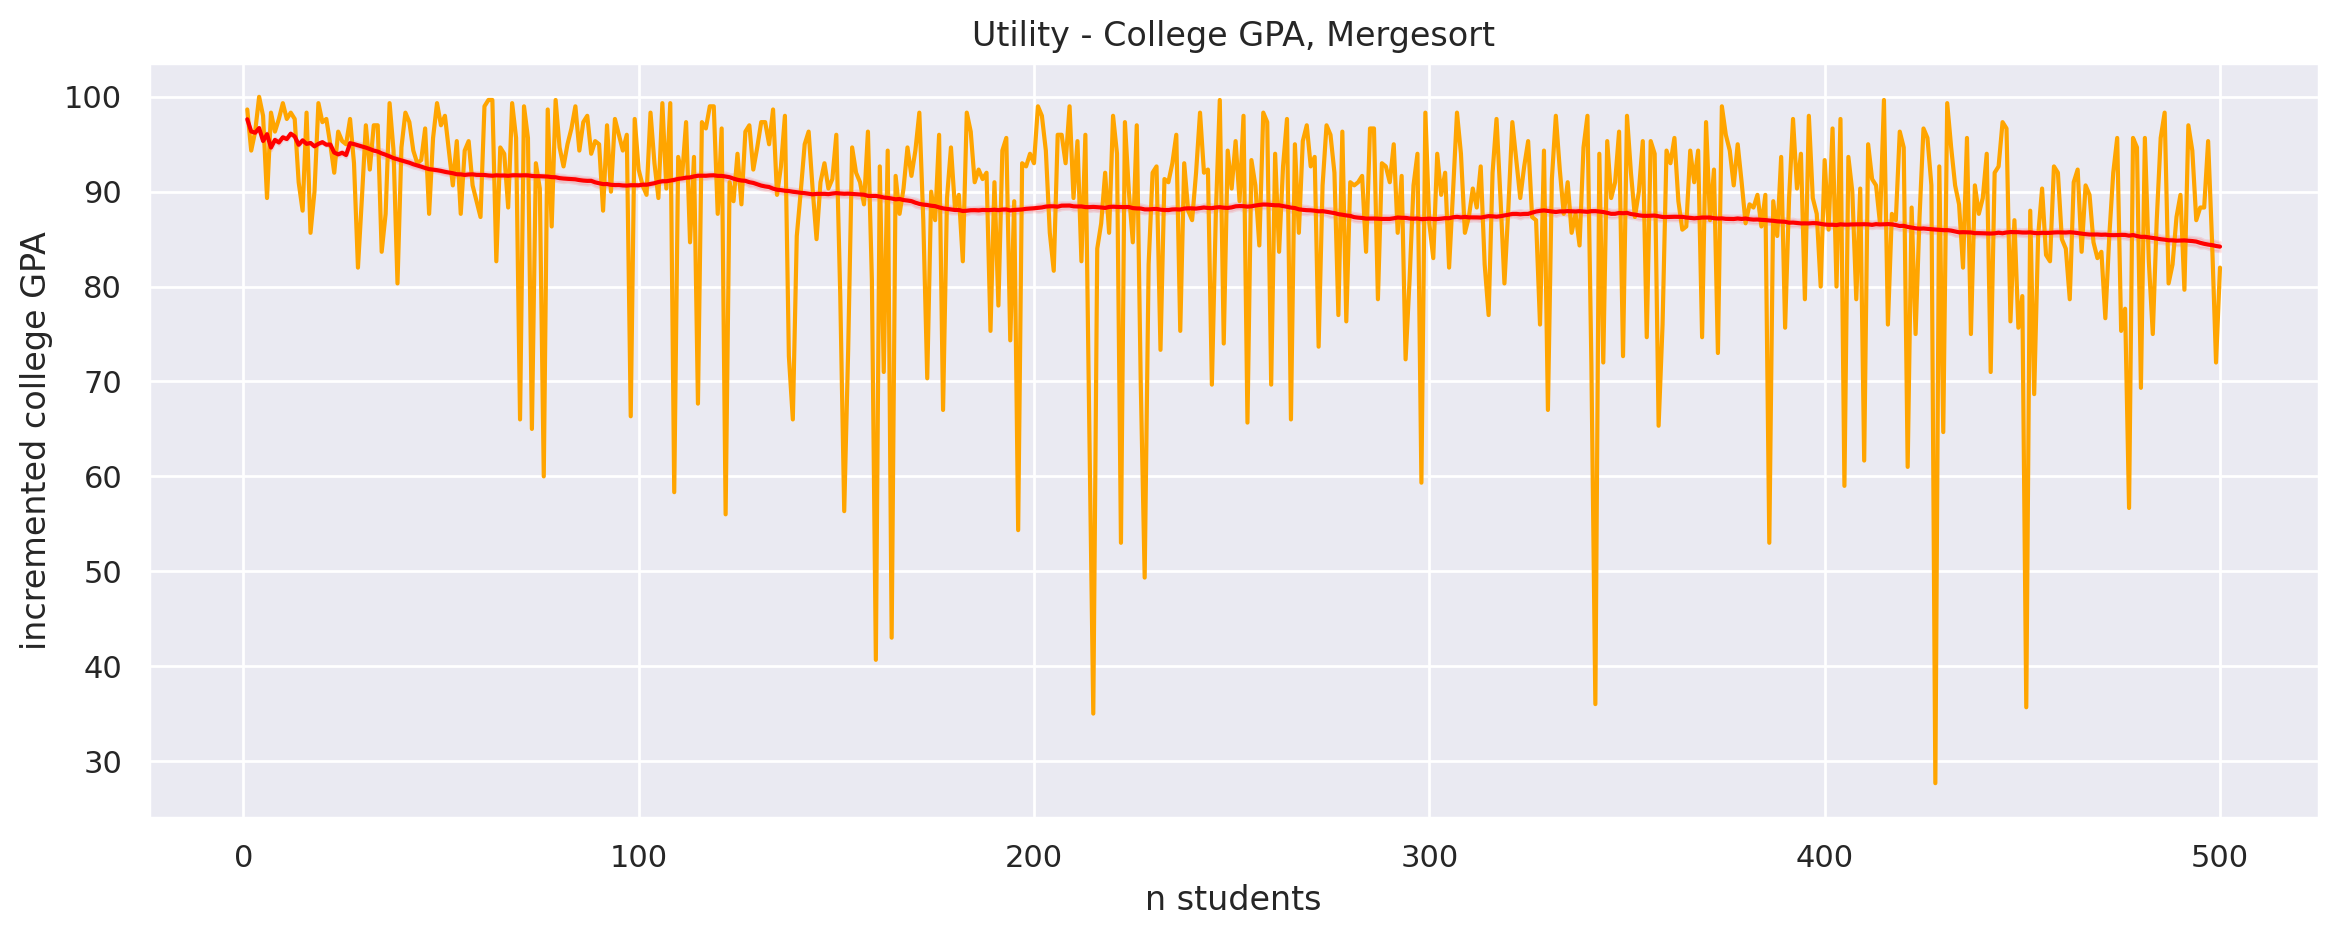

In [55]:
#mergesort 1 df
df_avg = df_sort.copy()
df_avg["incr_col_mean"] = df_avg['COL_GRADE_AVG']#.rolling(10).mean()#.expanding().mean()
df_avg["n_students"] = range(1,len(df_avg)+1)
sns.lineplot(x="n_students", y="incr_col_mean", data=df_avg[:500], color="orange").set_title("Utility - College GPA, Mergesort")

#mergesort 200 dfs
df_sort_BIG["n_students"] = range(1,len(df_sort_BIG)+1)
sns.lineplot(x="n_students", y="incr_col_mean", data=df_sort_BIG[:500], color="red").set_title("Utility - College GPA, Mergesort")

#std 200 dfs:
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG[0:500], alpha=0.1, color="red")

#alternative if errors above:
#plt.plot(df_sort_BIG["n_students"][0:500], df_sort_BIG["lower_std"][0:500], color='tab:red', alpha=0.1)
#plt.plot(df_sort_BIG["n_students"][0:500], df_sort_BIG["upper_std"][0:500][0:500], color='tab:red', alpha=0.1)
#plt.fill_between(df_sort_BIG["n_students"][0:500], df_sort_BIG["lower_std"][0:500], df_sort_BIG["upper_std"][0:500], alpha=0.2)


plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.show()


## Gendersort Ranker 
Choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking).

Merge sort for Female df and Male df and append and sort

Adding confidence interval


In [56]:
#Gendersort all
def gender_mergesort_all(df):
    df_temp = df.copy()
    df_M = df_temp[df_temp.GENDER_bin == 0]
    df_F = df_temp[df_temp.GENDER_bin == 1]
    
    df_sort_M = df_M.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort").reset_index()
    df_sort_F = df_F.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort").reset_index()

    if df_F.HI_GRADE_AVG.max() > df_M.HI_GRADE_AVG.max():
        sorted_with_gender = pd.concat([df_sort_F,df_sort_M], sort=False).sort_index()
    else: 
        sorted_with_gender = pd.concat([df_sort_M,df_sort_F], sort=False).sort_index()
    
    return sorted_with_gender.reset_index()
        

gender_df = gender_mergesort_all(df_for_Mergesort_single)


In [57]:
# df_test_use[:4096]

In [58]:
#Gendersort all
def gender_mergesort_BIG(df):
    

    dfs_test_use = df #= X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})
    FEMALES = pd.DataFrame()
    MALES= pd.DataFrame()
 
    for i in range(200):
        # df_test_use[i]
        fem=dfs_test_use[i][dfs_test_use[i]['4'] != 0]
        mal = dfs_test_use[i][dfs_test_use[i]['4'] != 1]


        fem= fem.sort_values(by="3", ascending=False, kind="mergesort").reset_index()
        mal= mal.sort_values(by="3", ascending=False, kind="mergesort").reset_index()
        # print(fem)
        FEMALES= FEMALES.append(fem)
        MALES=MALES.append(mal)

        


    FEMALES.index.names = ['INDEXES']
    MALES.index.names = ['INDEXES']
    
    
    # X_test_y_test_FULL = X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})
    # X_test_y_test_FULL_F = X_test_y_test_FULL[X_test_y_test_FULL.Gender_bins != 0]
    # X_test_y_test_FULL_M = X_test_y_test_FULL[X_test_y_test_FULL.Gender_bins != 1]

    # X_test_y_test_FULL_females = X_test_y_test_FULL_F.groupby('INDEXES').mean()

    
    #add std to plot it later
    FEMALES_std = FEMALES.groupby('INDEXES').std()/np.sqrt(200)
    MALES_std = MALES.groupby('INDEXES').std()/np.sqrt(200)
     
    FEMALES = FEMALES.groupby('INDEXES').mean().merge(FEMALES_std["18"], on="INDEXES", how="left")
    MALES = MALES.groupby('INDEXES').mean().merge(MALES_std["18"], on="INDEXES", how="left")
        
    if FEMALES['3'].max() > MALES['3'].max():
        sorted_with_gender = pd.concat([FEMALES,MALES], sort=False).sort_index()
    else: 
        sorted_with_gender = pd.concat([MALES,FEMALES], sort=False).sort_index()
        
    

    return sorted_with_gender.reset_index()
  

gender_df_BIG = gender_mergesort_BIG(dfs_test_use)


In [86]:
gender_df_BIG["incr_col_mean"] = gender_df_BIG['18_x'].rolling(25).mean()#.expanding().mean()
gender_df_BIG["incr_col_mean"][:26] = gender_df_BIG['18_x'][:26].rolling(3).mean()

gender_df_BIG["n_students"] = range(1,len(gender_df_BIG)+1)

<ipython-input-86-43e12ae7b1d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_df_BIG["incr_col_mean"][:26] = gender_df_BIG['18_x'][:26].rolling(3).mean()


In [88]:
#Adding standard deviation column for "incr_col_mean" and variables for plotting 200
gender_df_BIG["incr_half_std"] = 0.5*gender_df_BIG["18_y"] #0.5 of std to plot on both sides of mean
gender_df_BIG["lower_std"] = gender_df_BIG["incr_col_mean"] - gender_df_BIG["incr_half_std"]
gender_df_BIG["upper_std"] = gender_df_BIG["incr_col_mean"] + gender_df_BIG["incr_half_std"]

<ipython-input-89-32e634c93e58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_df["incr_col_mean"][:26] = gender_df['COL_GRADE_AVG'][:26].rolling(3).mean()


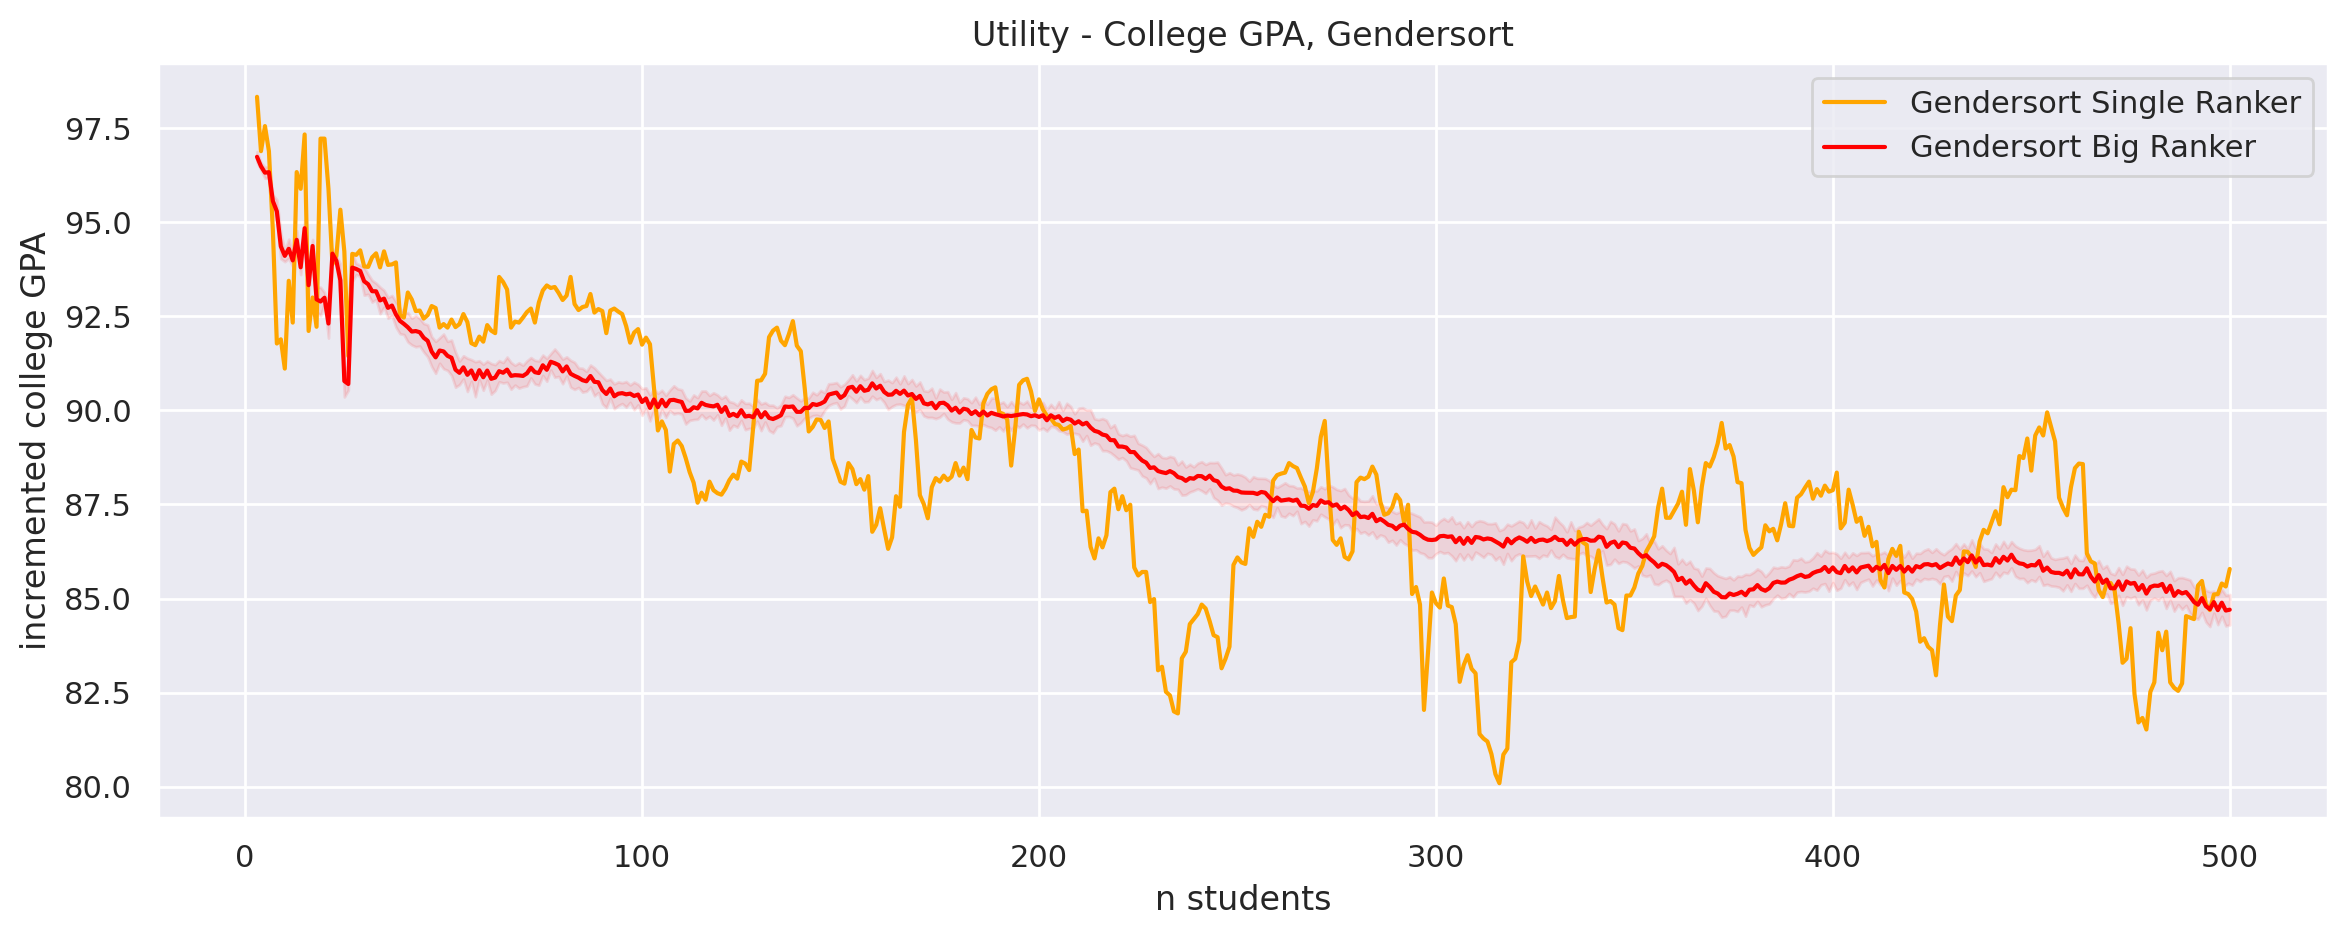

In [89]:
# The gendersort as function of n
#set the incremented col avg as column
import matplotlib
import matplotlib.pyplot as plt

gender_df["incr_col_mean"] = gender_df['COL_GRADE_AVG'].rolling(25).mean()#.expanding().mean()
gender_df["incr_col_mean"][:26] = gender_df['COL_GRADE_AVG'][:26].rolling(3).mean()
gender_df["n_students"] = range(1,len(gender_df)+1)
# Look of single lineplot of gendersort grades as function of n
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color="orange").set_title("Utility - College GPA, Gendersort")
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df_BIG[:500], color="red").set_title("Utility - College GPA, Gendersort")
#std 200 dfs:
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG[0:500], alpha=0.1, color="red")



plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.savefig('Gendersort_solo_200.png')
plt.legend(["Gendersort Single Ranker", "Gendersort Big Ranker"], loc ="upper right")

plt.show()

Forklaringen på, at Plain har lavere utility end without er, at without ikke trækker ned i karakter for kvinder. Without gør muligvis det, at den ikke udnervurderer i toppen. 


### Random sort utility
2000 samples of random dataframes are generated and plotted with std. as error bars


In [62]:
# # #Random generated dfs
# pd.options.mode.chained_assignment = None 

# df_use = df_for_Mergesort_single.copy()
# df_use = df_use[["Unnamed: 0","COL_GRADE_AVG", "GENDER_bin"]] #"STRATUM"

# for j in range(1,2): #first make one random df that we can append the other random dfs to
#     gen_state = random.seed(a=None) #random generator
#     df_random1 = shuffle(df_use, random_state=gen_state) #shuffle the df with a random generator based on time
#     df_random1["incr_col_mean"] = df_random1.COL_GRADE_AVG.expanding().mean()
#     df_random1["n_students"] = range(1,len(df_random1)+1)
#     for i in range(1000):
#         gen_state = random.seed(a=None)
#         df_random2 = shuffle(df_use, random_state=gen_state)
#         df_random2["incr_col_mean"] = df_random2.COL_GRADE_AVG.expanding().mean()
#         df_random2["n_students"] = range(1,len(df_random2)+1)
#         df_random1 = df_random1.append(df_random2)
# # #The random df to use

In [63]:
# # #only take n students from index 1-500
# indexs = np.arange(0,500)
# df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
# df_random_use = df_random_use.reset_index()
# #First we plot the random grades per n students
# # # w 2000 samples
# # #indexs = np.arange(0,500)
# # #df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
# #sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd")
# #plt.xlabel('n students')
# #plt.ylabel('incremented college GPA')
# #plt.title("Utility - College GPA, Random") 
# #plt.show()



## Plain XGBoost 

Using "preds" as College scores for XGBoost

Det skal tjekkes her, hvilken af de 3 grafer, der faktisk er den rigtige. 

In [64]:
# df_plain_TWO = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
# df_plain_TWO_std = df_plain_TWO.groupby('Unnamed: 0').std()/np.sqrt(200)
# df_plain_TWO_mean=  df_plain_TWO.groupby('Unnamed: 0').mean()
# df_plain_TWO_mean = df_plain_TWO_mean.sort_values(by=['Preds'], ascending=False)

# df_plain_TWO_mean["incr_col_mean"] = df_plain_TWO_mean['Preds']#.expanding().mean()
# df_plain_TWO_mean["n_students"] = range(1,len(df_plain_TWO_mean)+1)

# #Adding standard deviation column for "incr_col_mean" and variables for plotting 200
# df_plain_TWO_mean["incr_half_std"] = 0.5*df_plain_TWO_std["Preds"] #0.5 of std to plot on both sides of mean
# df_plain_TWO_mean["lower_std"] = df_plain_TWO_mean["incr_col_mean"] - df_plain_TWO_mean["incr_half_std"]
# df_plain_TWO_mean["upper_std"] = df_plain_TWO_mean["incr_col_mean"] + df_plain_TWO_mean["incr_half_std"]


# Kat_PLAIN_utility = sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
# plt.fill_between("n_students", "lower_std", "upper_std",data=df_plain_TWO_mean[0:500], alpha=0.1, color="cornflowerblue")
# plt.show()

In [74]:
GUDF = pd.read_csv('GUDF.csv')
y_test_TWO = pd.read_csv('TWO_samlet_preds_index_NY_PLAIN.csv')

import numpy as np
Splitte_PLAIN = np.array_split(y_test_TWO, 200)
GUDF['Idx'] = GUDF['Unnamed: 0'] 

# MERGESORT HERUNDER PÅ BIG 
Merged_PLAIN = pd.DataFrame()
for i in range(200):
    Splitte_PLAIN[i]= Splitte_PLAIN[i].sort_values(by="Preds", ascending=False, kind="mergesort")
    Splitte_PLAIN[i] = Splitte_PLAIN[i].merge(GUDF[['Idx','COL_GRADE_AVG']], on='Idx')
    Splitte_PLAIN[i]= Splitte_PLAIN[i].reset_index()
    Merged_PLAIN = Merged_PLAIN.append(Splitte_PLAIN[i])

Merged_PLAIN_use_std = Merged_PLAIN.copy()

,index,Unnamed: 0,Idx,Gender_bins,Preds,COL_GRADE_AVG
0,0,0,7490,1,92.565254,95.000000
1,1,1,12018,1,92.565254,99.000000
2,2,2,11864,1,92.565254,98.666667
3,3,3,12016,0,92.565254,99.333333
4,4,4,1089,0,92.477142,97.000000
...,...,...,...,...,...,...
4091,4091,4091,1195,0,23.099279,45.000000
4092,4092,4092,1856,0,23.005428,5.000000
4093,4093,4093,6742,0,23.005428,21.000000
4094,4094,4094,3588,0,22.907692,17.000000


In [76]:
Merged_PLAIN =  Merged_PLAIN.groupby('index').mean()
Merged_PLAIN_std =  Merged_PLAIN_use_std.groupby('index').std()/np.sqrt(200)

<ipython-input-94-17003ef7b262>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Merged_PLAIN["incr_col_mean"][:26] = Merged_PLAIN['COL_GRADE_AVG'][:26].rolling(3).mean()


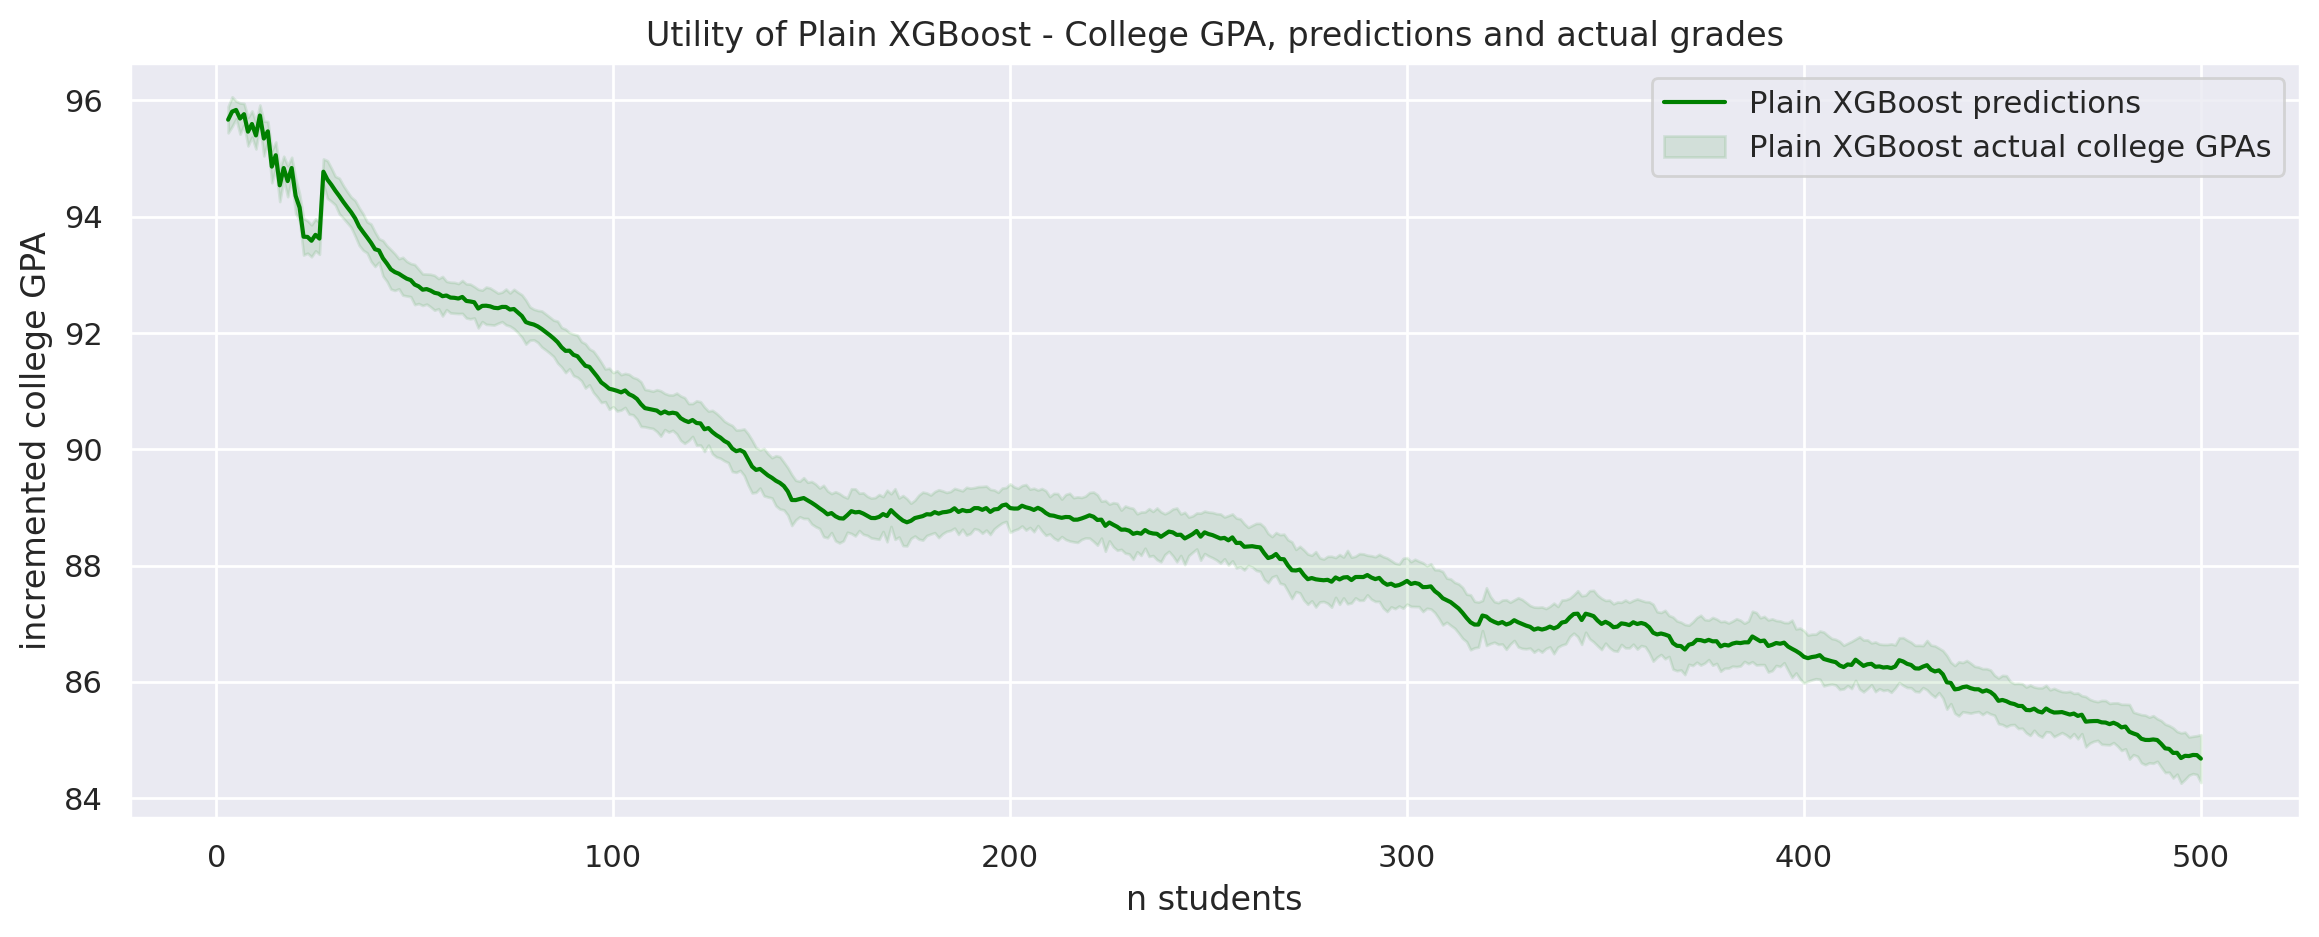

In [94]:


# Merged_PLAIN = Merged_PLAIN.sort_values('Preds',ascending=False)
# Merged_PLAIN["incr_col_mean"] = Merged_PLAIN['COL_GRADE_AVG'].expanding().mean()
Merged_PLAIN["incr_col_mean"] = Merged_PLAIN['COL_GRADE_AVG'].rolling(25).mean()
Merged_PLAIN["incr_col_mean"][:26] = Merged_PLAIN['COL_GRADE_AVG'][:26].rolling(3).mean()
Merged_PLAIN["n_students"] = range(1,len(Merged_PLAIN)+1)



#Adding standard deviation column for "incr_col_mean" and variables for plotting 200
Merged_PLAIN["incr_half_std"] = 0.5*Merged_PLAIN_std["COL_GRADE_AVG"] #0.5 of std to plot on both sides of mean
Merged_PLAIN["lower_std"] = Merged_PLAIN["incr_col_mean"] - Merged_PLAIN["incr_half_std"]
Merged_PLAIN["upper_std"] = Merged_PLAIN["incr_col_mean"] + Merged_PLAIN["incr_half_std"]



# Kat_PLAIN_utility = sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
# plt.fill_between("n_students", "lower_std", "upper_std",data=df_plain_TWO_mean[0:500], alpha=0.1, color="cornflowerblue")


Kat_PLAIN_utility = sns.lineplot(data=Merged_PLAIN[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[:500], alpha=0.1, color="green")


# Kat_PLAIN_utility = sns.lineplot(data=Merged_PLAIN[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")
# plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[:500], alpha=0.1, color="green")

# Kat_PLAIN_utility_w_o_CMA = sns.lineplot(data=Merged_PLAIN_w_o_CMA[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")
# plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[:500], alpha=0.1, color="green")





plt.xlabel('n students')
plt.ylabel('incremented college GPA')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.title('Utility of Plain XGBoost - College GPA, predictions and actual grades')
plt.legend(["Plain XGBoost predictions", 'Plain XGBoost actual college GPAs'], loc ="upper right")
plt.show()

## Without sensitive attributes XGBoost

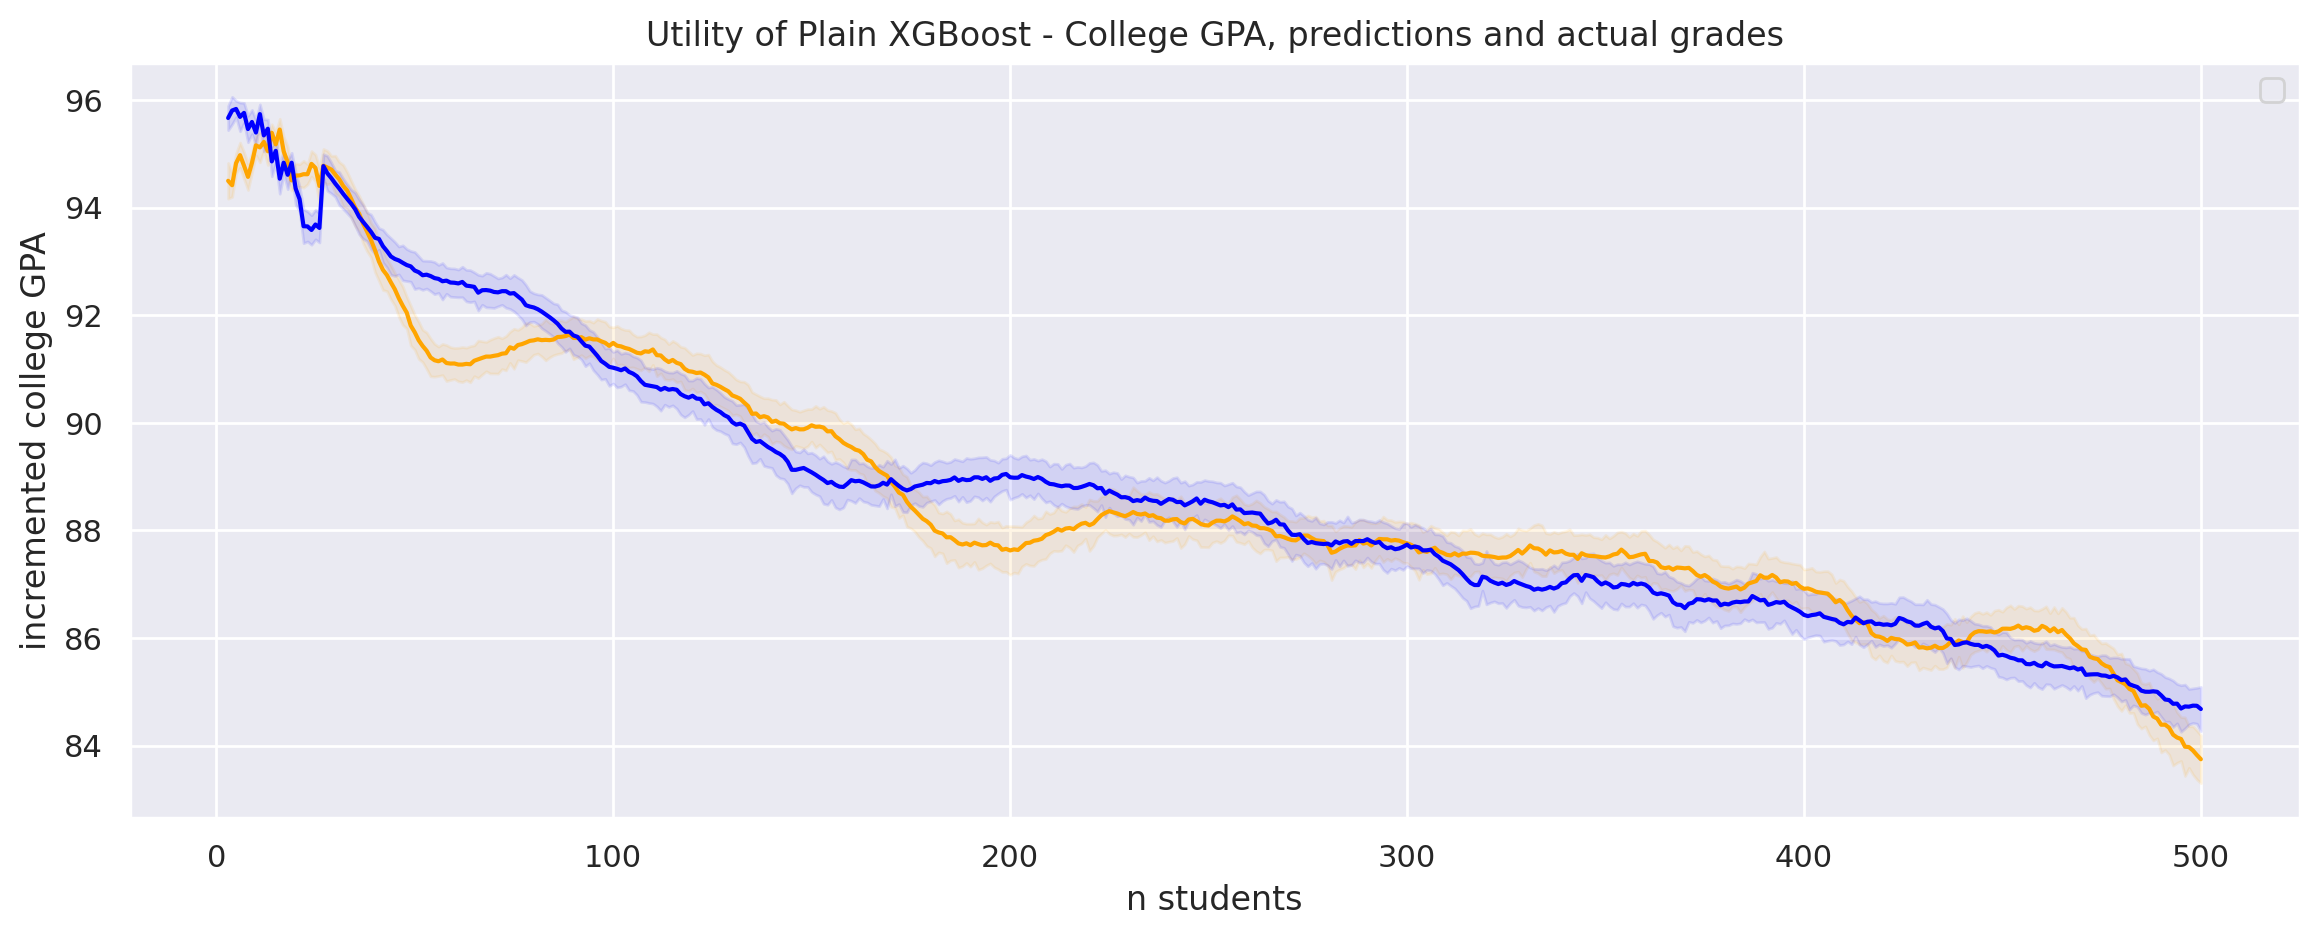

In [82]:
# WO XGBoost

GUDF = pd.read_csv('GUDF.csv')
y_test_TWO_WO = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')

import numpy as np
Splitte_WO = np.array_split(y_test_TWO_WO, 200)
GUDF['Idx'] = GUDF['Unnamed: 0'] 

# MERGESORT HERUNDER PÅ BIG 
Merged_WO = pd.DataFrame()
for i in range(200):
    Splitte_WO[i]= Splitte_WO[i].sort_values(by="Preds", ascending=False, kind="mergesort")
    Splitte_WO[i] = Splitte_WO[i].merge(GUDF[['Idx','COL_GRADE_AVG']], on='Idx')
    Splitte_WO[i]= Splitte_WO[i].reset_index()
    Merged_WO = Merged_WO.append(Splitte_WO[i])

Merged_WO_use_std = Merged_WO.copy()
Merged_WO =  Merged_WO.groupby('index').mean()
Merged_WO_std =  Merged_WO_use_std.groupby('index').std()/np.sqrt(200)


# add exp. mean
# Merged_WO = Merged_WO.sort_values('Preds',ascending=False)
Merged_WO["incr_col_mean"] = Merged_WO['COL_GRADE_AVG'].rolling(25).mean()#.expanding().mean()
Merged_WO["incr_col_mean"][:26] = Merged_WO['COL_GRADE_AVG'][:26].rolling(3).mean()
Merged_WO["n_students"] = range(1,len(Merged_WO)+1)

#add exp. std
Merged_WO["incr_half_std"] = 0.5*Merged_WO_std["COL_GRADE_AVG"] #0.5 of std to plot on both sides of mean
Merged_WO["lower_std"] = Merged_WO["incr_col_mean"] - Merged_WO["incr_half_std"]
Merged_WO["upper_std"] = Merged_WO["incr_col_mean"] + Merged_WO["incr_half_std"]



#plot Plain and WO
plt.xlabel('n students')
plt.ylabel('incremented college GPA')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.title('Utility of Plain XGBoost - College GPA, predictions and actual grades')
plt.legend(["Plain XGBoost predictions", 'Plain XGBoost actual college GPAs'], loc ="upper right")


sns.lineplot(data=Merged_WO[:500], x="n_students", y="incr_col_mean",  color="orange")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_WO[:500], alpha=0.1, color="orange")

sns.lineplot(data=Merged_PLAIN[:500], x="n_students", y="incr_col_mean",  color="blue")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[:500], alpha=0.1, color="blue")

plt.show()

Forklaringen på, at Plain har lavere utility end without er, at without ikke trækker ned i karakter for kvinder. Without gør muligvis det, at den ikke udnervurderer i toppen. 

# Fairness enhanced Ranker on 200 re-rankings

<AxesSubplot:title={'center':'Utility of Plain XGBoost - College GPA, predictions and actual grades'}, xlabel='n students', ylabel='incremented college GPA'>

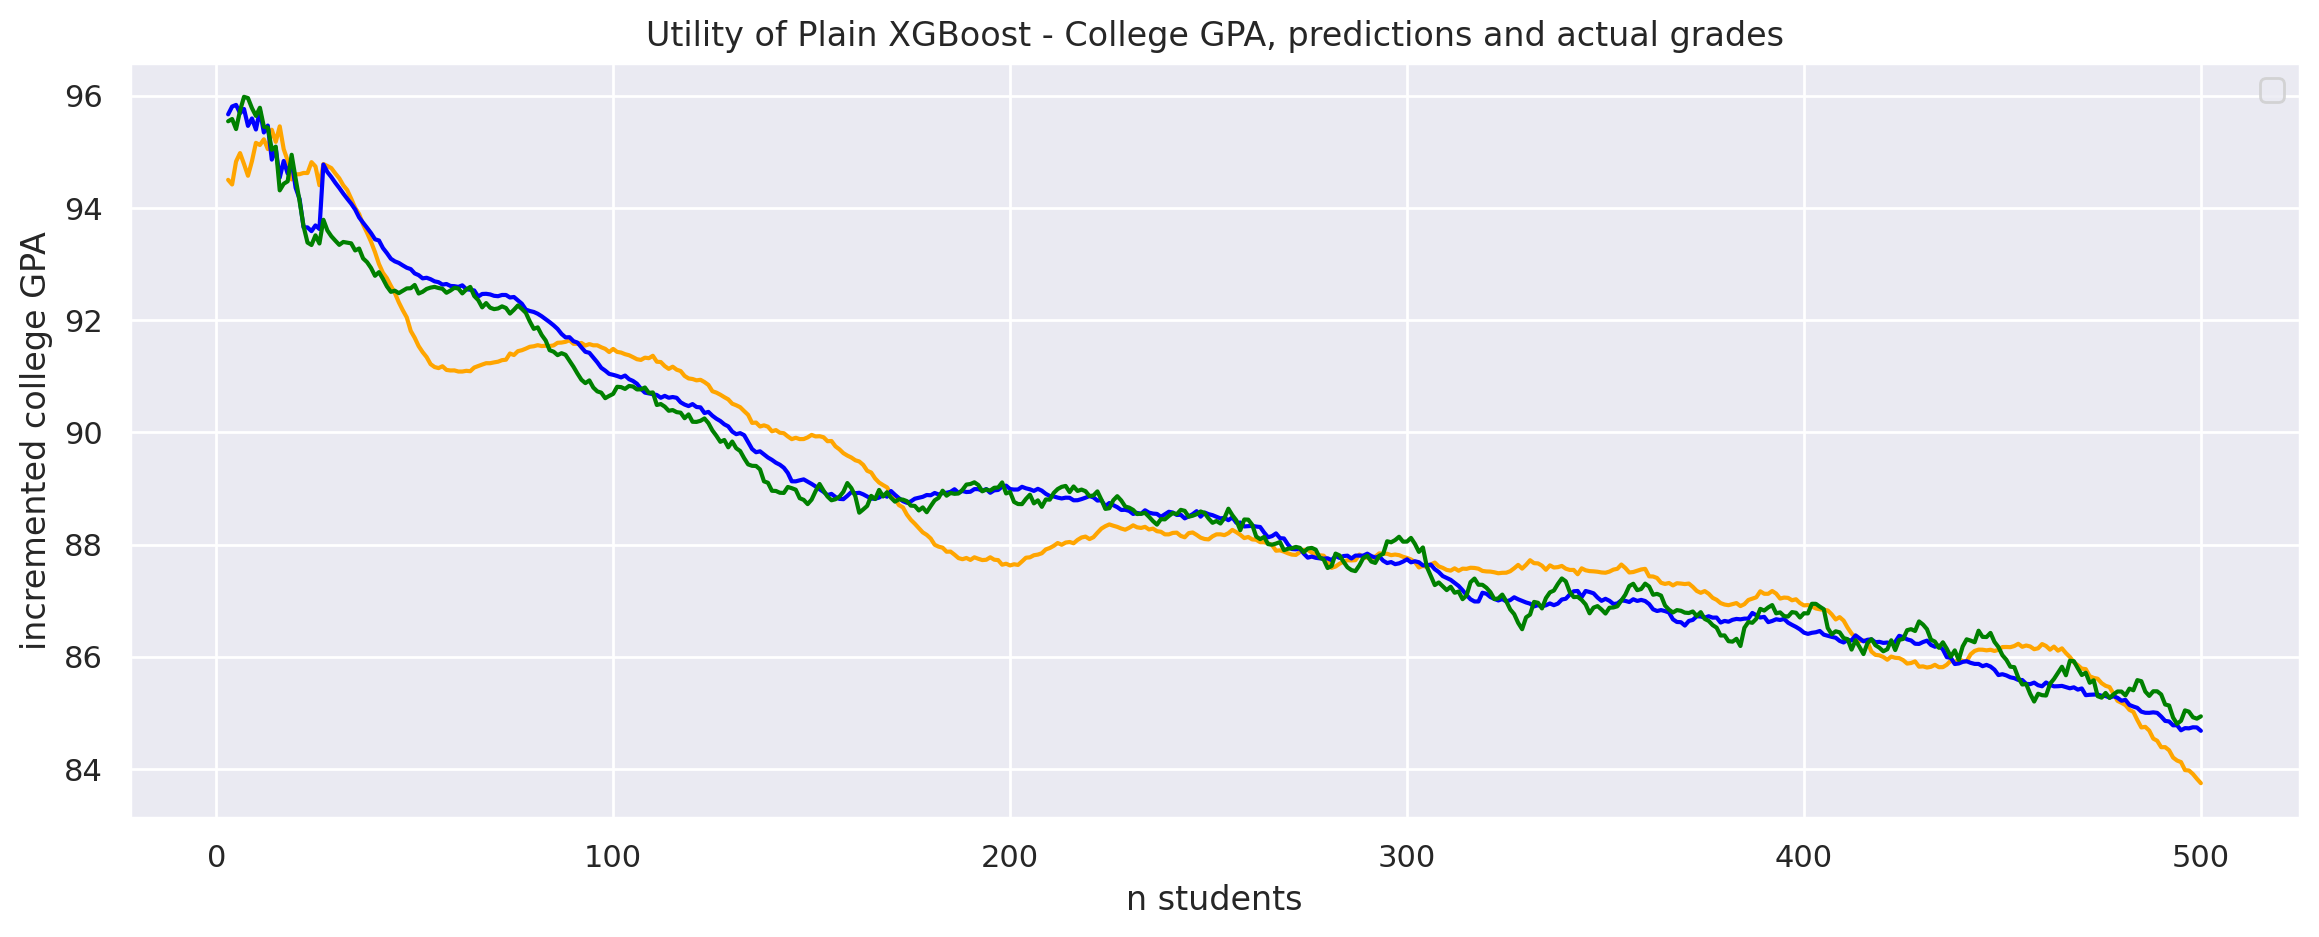

In [98]:
df_fair_TWO = pd.read_csv('re_ranked_199_NY.csv')


GUDF = pd.read_csv('GUDF.csv')
# df_fair_TWO = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')

import numpy as np
Splitte_FAIR = np.array_split(df_fair_TWO, 200)
GUDF['Idx'] = GUDF['Unnamed: 0'] 

# MERGESORT HERUNDER PÅ BIG 
Merged_FAIR = pd.DataFrame()
for i in range(200):
    Splitte_FAIR[i]= Splitte_FAIR[i].sort_values(by="Preds", ascending=False, kind="mergesort")
    Splitte_FAIR[i] = Splitte_FAIR[i].merge(GUDF[['Idx','COL_GRADE_AVG']], on='Idx')
    Splitte_FAIR[i]= Splitte_FAIR[i].reset_index()
    Merged_FAIR = Merged_FAIR.append(Splitte_FAIR[i])

Merged_FAIR_use_std = Merged_FAIR.copy()
Merged_FAIR =  Merged_FAIR.groupby('index').mean()
Merged_FAIR_std =  Merged_FAIR_use_std.groupby('index').std()/np.sqrt(200)


#add exp. mean
# Merged_FAIR = Merged_FAIR.sort_values('Preds',ascending=False)
Merged_FAIR["incr_col_mean"] = Merged_FAIR['COL_GRADE_AVG'].rolling(10).mean()#.expanding().mean()


Merged_FAIR_std["incr_col_error"] = Merged_FAIR_std['COL_GRADE_AVG'].rolling(10).mean()#.expanding().mean()

Merged_FAIR["incr_col_mean"][:26] = Merged_FAIR['COL_GRADE_AVG'][:26].rolling(3).mean()
Merged_FAIR["n_students"] = range(1,len(Merged_FAIR)+1)


#add exp. std
Merged_FAIR["incr_half_std"] = 0.5*Merged_FAIR_std["incr_col_error"] #0.5 of std to plot on both sides of mean
Merged_FAIR["lower_std"] = Merged_FAIR["incr_col_mean"] - Merged_FAIR["incr_half_std"]
Merged_FAIR["upper_std"] = Merged_FAIR["incr_col_mean"] + Merged_FAIR["incr_half_std"]



plt.xlabel('n students')
plt.ylabel('incremented college GPA')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.title('Utility of Plain XGBoost - College GPA, predictions and actual grades')
plt.legend(["Plain XGBoost predictions", 'Plain XGBoost actual college GPAs'], loc ="upper right")



sns.lineplot(data=Merged_WO[:500], x="n_students", y="incr_col_mean",  color="orange" , ci="sd")
sns.lineplot(data=Merged_PLAIN[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
sns.lineplot(data=Merged_FAIR[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")



In [69]:
# outdated
# sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color="pink").set_title("Utility - College GPA, Gendersort")
# sns.lineplot(data=df_plain_TWO_mean[k:l], x="n_students", y="incr_col_mean",  color="green" , ci="sd").set_title("Utility - College GPA, Gendersort")
# sns.lineplot(data=df_wo_TWO_mean[k:l], x="n_students", y="incr_col_mean",  color="orange").set_title("Utility - College GPA, Gendersort")
# FAKTISK DENNE VI SKAL BRUGE
# Kat_PLAIN_utility = sns.lineplot(data=y_test_KAT[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")


# All utilities (with CI)

In [70]:
# #Read fair
# df_fair_TWO = pd.read_csv('re_ranked_199_NY.csv')

# df_fair_TWO_std = df_fair_TWO.groupby('Unnamed: 0').std()/np.sqrt(200)

# df_fair_TWO_mean=  df_fair_TWO.groupby('Unnamed: 0').mean()
# # df_fair_TWO_mean
# df_fair_TWO_mean = df_fair_TWO_mean.sort_values(by=['Preds'], ascending=False)
# df_fair_TWO_mean["incr_col_mean"] = df_fair_TWO_mean['Preds']#.expanding().mean()


# #cumsum of index to use for plot
# df_fair_TWO_mean["n_students"] = range(1,len(df_fair_TWO_mean)+1)



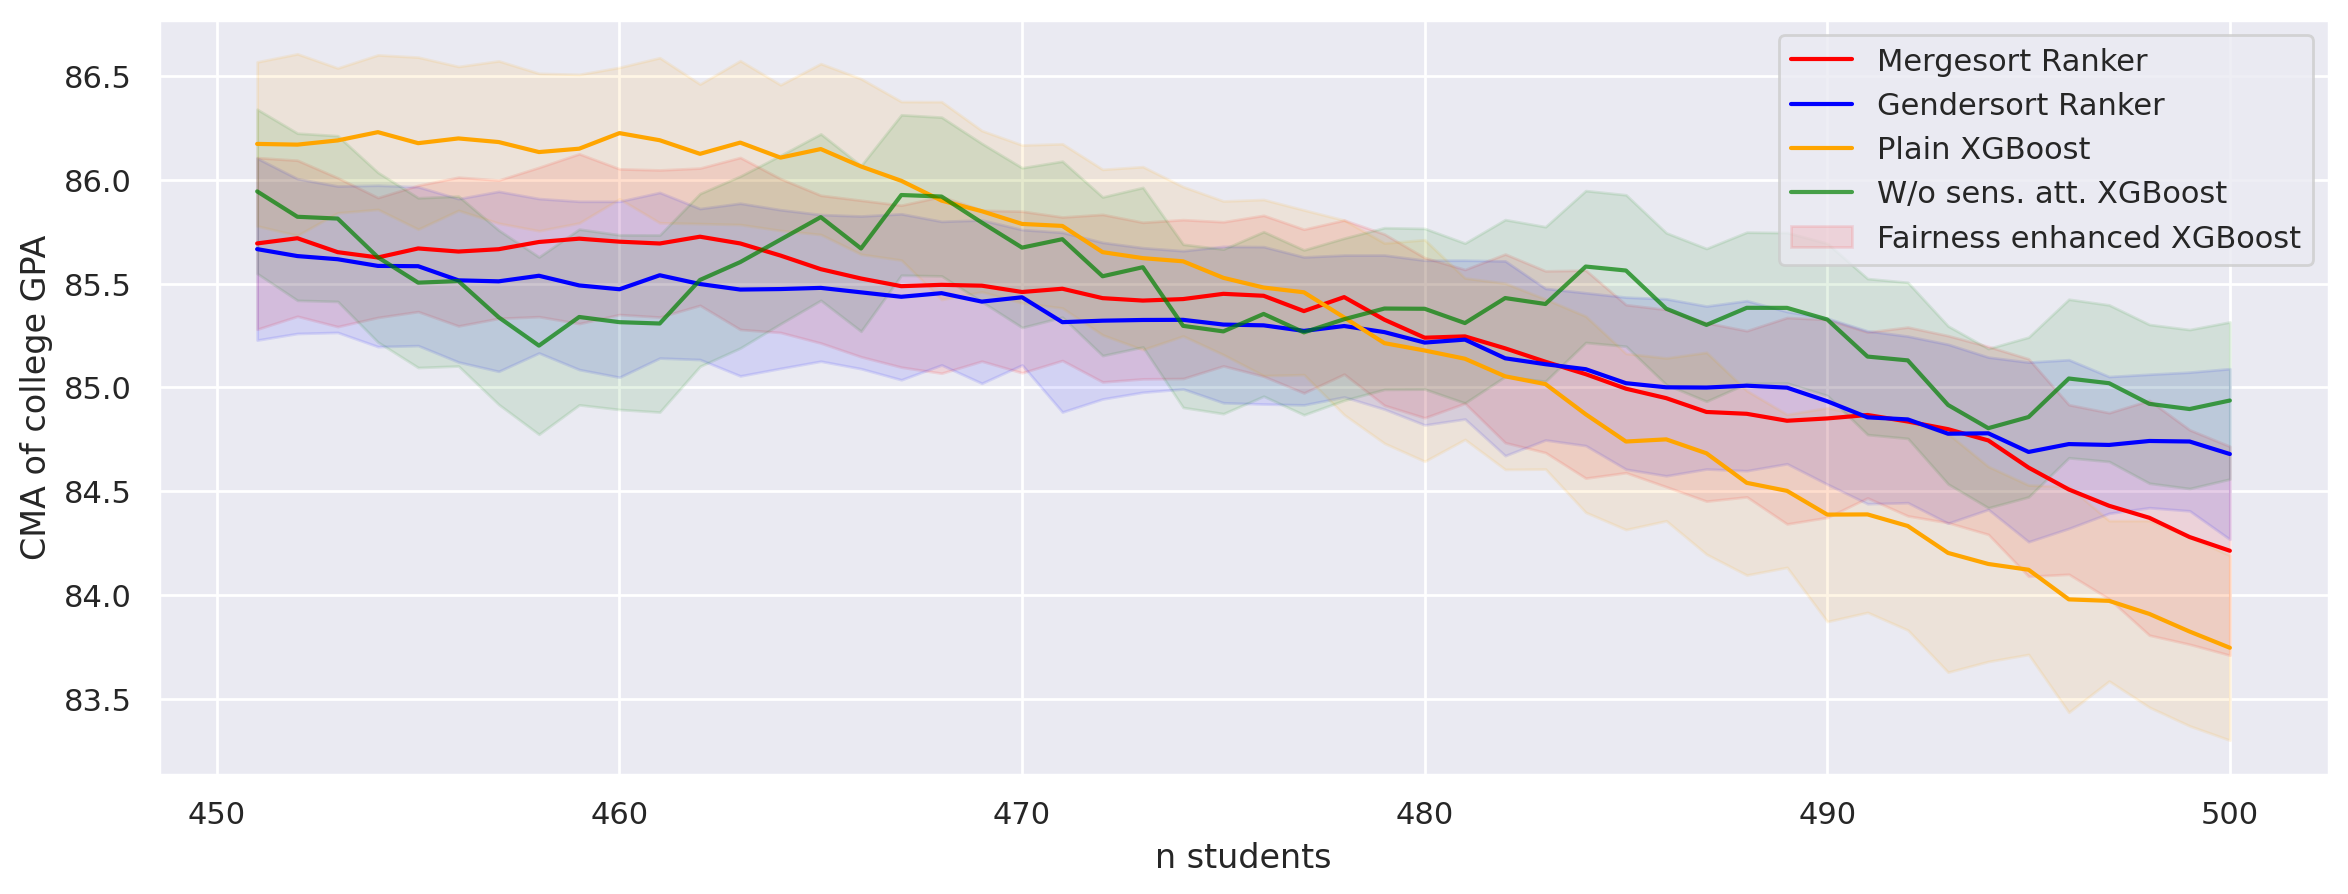

<Figure size 2800x1000 with 0 Axes>

In [99]:
# xgboost 200
k=450
l=500

# Mergesort and gendersort rankers
sns.lineplot(x="n_students", y="incr_col_mean", data=df_sort_BIG[k:l], color="red")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG[k:l], alpha=0.1, color="red")

# sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df_BIG[k:l], color="purple")
# plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG[k:l], alpha=0.1, color="purple")


#XGBoosts
sns.lineplot(data=Merged_PLAIN[k:l], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[k:l], alpha=0.1, color="blue")

sns.lineplot(data=Merged_WO[k:l], x="n_students", y="incr_col_mean",  color="orange" , ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_WO[k:l], alpha=0.1, color="orange")

sns.lineplot(data=Merged_FAIR[k:l], x="n_students", y="incr_col_mean",  color="green" , ci="sd", alpha=0.7)
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_FAIR[k:l], alpha=0.1, color="green")


#random
#sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd")

#plot
plt.xlabel('n students')
plt.ylabel('CMA of college GPA')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
#plt.title('Utility of models - College GPA, all rankers')
plt.legend(["Mergesort Ranker", "Gendersort Ranker", "Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost"], loc ="upper right")
# plt.legend(["Mergesort Ranker", "Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost"], loc ="upper right")

plt.show()
plt.savefig('ALL_utility.png')

In [72]:
# # xgboost 200 FAIR and x
# k=0
# l=500


# #XGBoosts
# sns.lineplot(data=Merged_PLAIN[k:l], x="n_students", y="incr_col_mean",  color="blue" , ci="sd").set_title("Utility - College GPA, XGBoost w/o sens. att. ")
# plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[k:l], alpha=0.1, color="blue")

# sns.lineplot(data=Merged_FAIR[k:l], x="n_students", y="incr_col_mean",  color="green" , ci="sd", alpha=0.7).set_title("Utility - College GPA, Gendersort")
# plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_FAIR[k:l], alpha=0.1, color="green")


# #plot
# plt.xlabel('n students')
# plt.ylabel('incremented college GPA')
# # plt.title("Averge grade as a function of n student, baselines and XGBoost")
# plt.title('Utility of models - College GPA, Plain and x')
# plt.legend(["Plain XGBoost", "Fairness enhanced XGBoost"], loc ="upper right")
# plt.show()
# #plt.savefig('ALL_utility.png')